In [ ]:
import numpy as np 
import pandas as pd 
import os
print(os.listdir("/content/img_align_celeba"))


['img_align_celeba']


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import copy
import time
import cv2 as cv
from tqdm import tqdm_notebook as tqdm
import matplotlib.image as mpimg

In [ ]:
datapath = "/content/img_align_celeba/img_align_celeba/"
images_path = os.listdir("/content/img_align_celeba/img_align_celeba/")
print(len(images_path))
images_path = images_path[:30000]
valid_ratio = 0.8

202599


In [ ]:
class ImageData(Dataset):
    def __init__(self,is_train=True):
        self.is_train = is_train
        self.transform = transforms.Compose([transforms.ToTensor(),])
        self.train_index = int(valid_ratio * len(images_path))
    def __len__(self):
        if self.is_train:
            return self.train_index
        else:
            return len(images_path) - self.train_index -1
    def __getitem__(self, index):
        if not self.is_train:
            index = self.train_index + index
        img = mpimg.imread(datapath+str(images_path[index]))
        if self.transform is not None:
            img = self.transform(img)
        img = (img - 0.5) / 0.5
        return img

In [ ]:
batch_size=20
dataset = ImageData()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
device = 'cuda'

torch.Size([3, 218, 178])


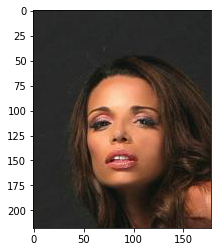

In [ ]:
a = next(iter(dataloader))
print(a[0].shape)
img = a[15]
img = img *0.5 + 0.5
plt.imshow(img.permute(1,2,0))

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
IMG_WIDTH = 178
IMG_HEIGHT = 218
encode_size = [30,30]
latent_size = 200

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3,stride = 1,padding=0),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5,stride = 2,padding=0),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=3,stride = 2,padding=2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3,stride = 1,padding=2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3,stride = 1,padding=0),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        return x

In [ ]:
device

'cuda'

In [ ]:
netE = Encoder().to(device)
netE.apply(weights_init)
inp = torch.randn(IMG_WIDTH*IMG_HEIGHT*3 * 100)
inp = inp.view((-1,3,IMG_HEIGHT,IMG_WIDTH))
output = netE(inp.to(device))
print(output.shape)
print((output.shape[0]*output.shape[1]*output.shape[2])/(IMG_WIDTH*IMG_HEIGHT*3))

torch.Size([100, 8, 54, 44])
0.37109576332336874


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.latent_fc1 = nn.Sequential(
            nn.Linear(latent_size,1000),
            nn.Sigmoid(),
        )
        self.latent_fc2 = nn.Sequential(
            nn.Linear(1000,54*44),
            nn.Sigmoid(),
        )
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(9, 16, (3,3), stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(16, 32, (3,3), stride=1, padding=2, output_padding=0, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(32, 128, (3,3), stride=2, padding=2, output_padding=1, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, (5,5), stride=2, padding=0, output_padding=1, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.layer5 = nn.Sequential(
            nn.ConvTranspose2d(64, 3, (3,3), stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Sigmoid(),
        )    
        
    def forward(self, x):
        y = x['noise'].to(device)
        y = self.latent_fc1(y)
        y = self.latent_fc2(y)
        y = y.view(-1,1,54,44)

        x = x['encoded'].to(device)
        x = torch.cat((x,y),1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        return x

In [ ]:
netG = Generator().to(device)
netG.apply(weights_init)
inp = {}
inp['encoded'] = torch.randn(100*8*54*44).view((-1,8,54,44))
inp['noise'] = torch.randn(100*latent_size).view((-1,latent_size))
output = netG(inp)
print(output.shape)


torch.Size([100, 3, 218, 178])


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.latent_layer1 = nn.Sequential(
            nn.ConvTranspose2d(8, 12, (3,3), stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.latent_layer2 = nn.Sequential(
            nn.ConvTranspose2d(12, 16, (3,3), stride=1, padding=2, output_padding=0, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.latent_layer3 = nn.Sequential(
            nn.ConvTranspose2d(16, 24, (3,3), stride=2, padding=2, output_padding=1, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.latent_layer4 = nn.Sequential(
            nn.ConvTranspose2d(24, 36, (5,5), stride=2, padding=0, output_padding=1, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.latent_layer5 = nn.Sequential(
            nn.ConvTranspose2d(36, 3, (3,3), stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Tanh(),
        )
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=64, kernel_size=3,stride = 1,padding=0),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5,stride = 2,padding=0),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=3,stride = 2,padding=2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3,stride = 1,padding=2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3,stride = 1,padding=0),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Tanh(),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(8*54*44,2000),
            nn.Sigmoid(),
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(2000,100),
            nn.Sigmoid(),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(100,1),
            nn.Sigmoid(),
        )    
    def forward(self, x):
        y = x['encoded'].to(device)
        y = self.latent_layer1(y)
        y = self.latent_layer2(y)
        y = self.latent_layer3(y)
        y = self.latent_layer4(y)
        y = self.latent_layer5(y)
        x = x['img'].to(device)
        x = torch.cat((x,y),1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x= x.reshape((x.shape[0],-1))
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [ ]:
netD = Discriminator().to(device)
netD.apply(weights_init)
inp_x = {}
inp_x['img']=torch.randn(IMG_WIDTH*IMG_HEIGHT*3 * 100).view((-1,3,IMG_HEIGHT,IMG_WIDTH))
inp_x['encoded'] = torch.randn(100*8*54*44).view((-1,8,54,44))
output = netD(inp_x)
output.shape

torch.Size([100, 1])

In [ ]:
lr = 0.0002
criterion = nn.BCELoss()
msecriterion = nn.MSELoss()
fixed_noise = torch.randn(64, 200, device=device)
real_label = 1
fake_label = 0
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerE = optim.Adam(netE.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
img_list = []
G_losses = []
D_losses = []
E_losses = []
iters = 0
num_epochs = 4

#torch.autograd.set_detect_anomaly(True)
print("Starting Training Loop...")

for epoch in range(num_epochs):
    for i, (images) in enumerate(dataloader, 0):
        netG.train()
        netD.train()
        netE.train()
        netD.zero_grad()
        
        images = images.to(device)
        
        x_inp_G = {}
        x_inp_G['encoded'] = netE(images)
        x_inp_G['noise'] = torch.randn(images.size(0)*latent_size).view((-1,latent_size))
        fake_images = netG(x_inp_G)
        inp_x = {}
        inp_x['img']=images
        inp_x['encoded'] = netE(images)

        label = torch.FloatTensor(np.random.uniform(low=0.855, high=0.999, size=(images.size(0)))).to(device)
        output = netD(inp_x).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward(retain_graph=True)
        D_x = output.mean().item()
        
        inp_x_fake = {}
        inp_x_fake['img']=fake_images
        inp_x_fake['encoded'] = netE(images)
        label = torch.FloatTensor(np.random.uniform(low=0.005, high=0.155, size=(images.size(0)))).to(device)
        output = netD(inp_x_fake).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward(retain_graph=True)
        D_G_z1 = output.mean().item()
        
        errD = errD_real + errD_fake
        
        optimizerD.step()
        netG.zero_grad()
        inp_x_fake = {}
        inp_x_fake['img']=fake_images
        inp_x_fake['encoded'] = netE(images)
        
        label = torch.FloatTensor(np.random.uniform(low=0.895, high=0.999, size=(images.size(0)))).to(device)
        output = netD(inp_x_fake).view(-1)
        
        errG = criterion(output, label) + msecriterion(images,fake_images)
        errG.backward(retain_graph=True)
        D_G_z2 = output.mean().item()
        optimizerG.step()

        
        netG.zero_grad()
        inp_x_fake = {}
        inp_x_fake['img']=fake_images
        inp_x_fake['encoded'] = netE(images)
        
        label = torch.FloatTensor(np.random.uniform(low=0.895, high=0.999, size=(images.size(0)))).to(device)
        output = netD(inp_x_fake).view(-1)
        
        errE = criterion(output, label) + msecriterion(images,fake_images)
        errE.backward(retain_graph=True)
        E_G_z2 = output.mean().item()
        optimizerE.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

     
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        E_losses.append(errE.item())
        del images
        del inp_x_fake
        del inp_x
        del label
        del output
        del x_inp_G
        torch.cuda.empty_cache()
        iters += 1

#torch.autograd.set_detect_anomaly(True)        

Starting Training Loop...
[0/4][0/1200]	Loss_D: 1.3883	Loss_G: 1.5589	D(x): 0.5241	D(G(z)): 0.5241 / 0.4563
[0/4][50/1200]	Loss_D: 0.5441	Loss_G: 2.4279	D(x): 0.9170	D(G(z)): 0.1158 / 0.1114
[0/4][100/1200]	Loss_D: 0.5953	Loss_G: 2.7216	D(x): 0.9066	D(G(z)): 0.0844 / 0.0877
[0/4][150/1200]	Loss_D: 0.4867	Loss_G: 2.7497	D(x): 0.9284	D(G(z)): 0.0796 / 0.0771
[0/4][200/1200]	Loss_D: 0.5692	Loss_G: 2.8163	D(x): 0.9275	D(G(z)): 0.0769 / 0.0772
[0/4][250/1200]	Loss_D: 0.5785	Loss_G: 2.7598	D(x): 0.9267	D(G(z)): 0.0781 / 0.0791
[0/4][300/1200]	Loss_D: 0.5817	Loss_G: 2.6900	D(x): 0.9294	D(G(z)): 0.0811 / 0.0792
[0/4][350/1200]	Loss_D: 0.5643	Loss_G: 2.7108	D(x): 0.9265	D(G(z)): 0.0782 / 0.0771
[0/4][400/1200]	Loss_D: 0.5160	Loss_G: 2.7546	D(x): 0.9288	D(G(z)): 0.0836 / 0.0801
[0/4][450/1200]	Loss_D: 0.5079	Loss_G: 2.7328	D(x): 0.9277	D(G(z)): 0.0814 / 0.0783
[0/4][500/1200]	Loss_D: 0.5786	Loss_G: 2.6460	D(x): 0.9268	D(G(z)): 0.0868 / 0.0848
[0/4][550/1200]	Loss_D: 0.5750	Loss_G: 2.8616	D(x): 0

In [ ]:
print("Evaluating the model ...")
netE.eval()
netG.eval()
tot_img_size = IMG_WIDTH * IMG_HEIGHT * 3

Evaluating the model ...


In [ ]:
valid_dataset = ImageData(is_train=False)
batch_size=20
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
valid_batch = next(iter(valid_dataloader)).to(device)

In [ ]:
print(valid_batch.shape)
encoded_img = netE(valid_batch)
print(encoded_img.shape)
x_inp_G = {}
x_inp_G['encoded'] = encoded_img
x_inp_G['noise'] = torch.randn(valid_batch.shape[0]*latent_size).view((-1,latent_size))
reconstructed_img = netG(x_inp_G)
print(reconstructed_img.shape)

torch.Size([20, 3, 218, 178])
torch.Size([20, 8, 54, 44])
torch.Size([20, 3, 218, 178])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

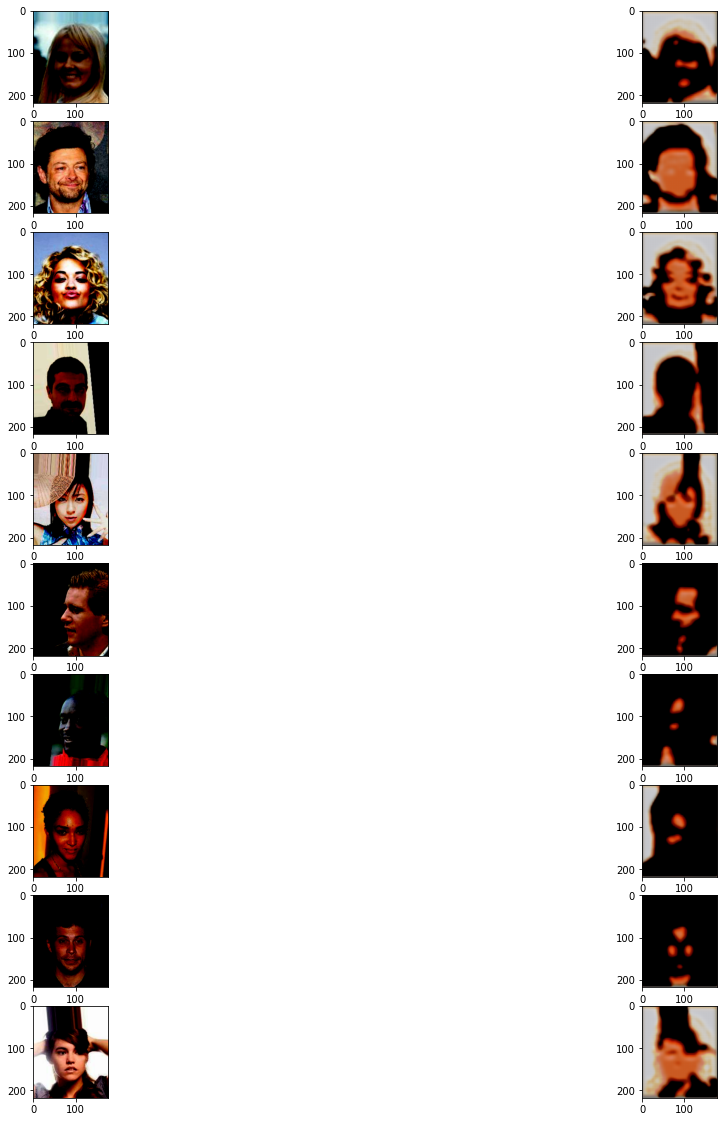

In [ ]:
num_images_to_show =10
f, axarr = plt.subplots(num_images_to_show,2)
for i in range(num_images_to_show):
    axarr[i,0].imshow(valid_batch[i].cpu().detach().permute(1, 2, 0))
    axarr[i,1].imshow(reconstructed_img[i].cpu().detach().permute(1, 2, 0))
    f.set_figheight(20)
    f.set_figwidth(20)
plt.show()